## Microsoft Object Detection Explainability (D-RISE) Tutorial

Authors: Raphi Kang, Shreya Ravikumar. 2023 internship at Microsoft Explainable AI Team, with Ilya Matiach, Jimmy Hall

This tutorial will walk us through the process of fine-tuning a pretrained object detection model, then generating saliency maps with the [D-RISE (Detector Randomized Input Sampling for Explanation)](https://arxiv.org/abs/2006.03204) method. The same results can also be achieved by using our python package [vision-explanation-methods](https://github.com/microsoft/vision-explanation-methods).
D-RISE is a black-boxed, or model-agnostic, explainability method which can produce saliency maps for any object detection or instance segmentation models provided these models are appropriately wrapped. In essence, D-RISE works by random masking the input images and isolating the parts that are most pertinent for the detection or segmentation of the object in question.  In this implementation, we introduce a custom wrapper class for PyTorch FastRCNN models, and provide the option for the user to define their own wrapper class.

First we install all necessary dependencies and import them.

In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00


In [ ]:
!pip install BeautifulSoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will also install the vision-explanation-methods package for access its dependencies.

In [1]:
!pip install git+https://github.com/microsoft/vision-explanation-methods.git#subdirectory=python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/microsoft/vision-explanation-methods.git to /tmp/pip-req-build-lxtay2kl
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/vision-explanation-methods.git /tmp/pip-req-build-lxtay2kl
  Resolved https://github.com/microsoft/vision-explanation-methods.git to commit 4ba2bc3cc5dddce58728f7348d3b7bebf080b81b
  Preparing metadata (setup.py) ... done
  Created wheel for vision-explanation-methods: filename=vision_explanation_methods-0.0.2-py3-none-any.whl size=13213 sha256=c590eb96022204cace74b2d2bc65d48684b9f797278043ca7b2292b66c1cb301
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4ql0b5v/wheels/a7/5f/c9/10ec794eab012d31cc2cee428693c917dea86553c409bccd3c
Successfully built vision-explanation-methods


# 1. Fine-tuning an Object Detection Model

If you already have a pretrained model you would like to load, you can skip to the next portion. In this section, we will be showing how to finetune a Faster R-CNN model on a recycling dataset. Many of the steps follow the TorchVision Object Detection Finetuning tutorial. (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html. 

### Recyling finetuning - creating the dataset




First, let's download and extract the data from Microsoft computer-vision recipes.

In [ ]:
# download the Fridge objects dataset from Microsoft computer-vision recipes
!wget https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip .
# extract it in the current folder
!unzip odFridgeObjects.zip

--2023-02-01 20:12:46--  https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip
Resolving cvbp-secondary.z19.web.core.windows.net (cvbp-secondary.z19.web.core.windows.net)... 20.60.181.238
Connecting to cvbp-secondary.z19.web.core.windows.net (cvbp-secondary.z19.web.core.windows.net)|20.60.181.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20380998 (19M) [application/x-zip-compressed]
Saving to: ‘odFridgeObjects.zip’

odFridgeObjects.zip 100%[===================>]  19.44M  12.6MB/s    in 1.5s    

2023-02-01 20:12:48 (12.6 MB/s) - ‘odFridgeObjects.zip’ saved [20380998/20380998]

--2023-02-01 20:12:48--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-02-01 20:12:48--
Total wall clock time: 2.0s
Downloaded: 1 files, 19M in 1.5s (12.6 MB/s)
Archive:  odFridgeObjects.zip
   creating: odFridgeObjects/
  inflating: odFridgeObjects/.DS_Store

Now let's write a custom dataset for the odFridgeObjects dataset with data augmentation. 

In [ ]:
#@title Data augmentation 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Set train=True for training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5),
                            A.VerticalFlip(p=0.2),
                            A.CropAndPad(percent = (0, 0.1)),
                            A.GaussianBlur(sigma_limit = 0.05, p = 0.5),
                            A.RandomBrightnessContrast(brightness_limit = 0.05, contrast_limit = 0.05, p = 0.5),
                            A.Affine(
                                    scale= {"x": (1, 1.5), "y": (1, 1.5)},
                                    translate_percent={"x": (0, 0.05), "y": (0, 0.05)},
                                    rotate=[-3, 3],
                            ),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
#@title Defining the Fridge Dataset class 
import torch
import torch.utils.data
import cv2
from bs4 import BeautifulSoup 
from torchvision.transforms import functional as F

class FridgeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images/"))))[2:]
        self.boxes = list(sorted(os.listdir(os.path.join(root, "annotations/"))))[2:]

    def __getitem__(self, idx):
        # load images 
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        box_path = os.path.join(self.root, "annotations", self.boxes[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # get bounding box coordinates and labels for each annotation
        with open(box_path, 'r') as f:
            data = f.read() 

        bs_data = BeautifulSoup(data, 'xml') 
        xmin = bs_data.find_all('xmin') 
        xmax = bs_data.find_all('xmax') 
        ymin = bs_data.find_all('ymin') 
        ymax = bs_data.find_all('ymax') 

        label = bs_data.find_all('name') 
        label_dict = {'can': 1, 'carton': 2, 'milk_bottle': 3, 'water_bottle': 4}

        boxes = []
        labels = []
        for i in range(0,len(xmin)):
            box = [int(xmin[i].get_text()),int(ymin[i].get_text()),
                    int(xmax[i].get_text()),int(ymax[i].get_text())]
            boxes.append(box)
            labels.append(label_dict[label[i].get_text()])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(label),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # apply transforms to 
        if self.transforms:
            transform = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = target['labels'])
                
            img = transform['image']
            target['boxes'] = torch.Tensor(transform['bboxes'])
                
        img = F.convert_image_dtype(img, torch.float)
        return img, target

    def __len__(self):
        return len(self.imgs)

### Recyling finetuning - training the model


First, we need to install all the necessary dependencies and import them. 

In [ ]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8f7r3ehk
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8f7r3ehk
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=421021 sha256=38603016b64c17307e329ce7b85cc8b6d460a92b3051a183c05f40da11330f7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zk_bjny5/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.


There are helper functions to simplify training and evaluating object detection models in the references/detection/ subdirectory of TorchVision. Here, we will use references/detection/engine.py, references/detection/utils.py and references/detection/transforms.py.

Let's copy those files (and their dependencies) in here so that they are available in the notebook.

In [ ]:
# Download TorchVision repo to use some files from references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 290208, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 290208 (delta 0), reused 0 (delta 0), pack-reused 290206
Receiving objects: 100% (290208/290208), 581.63 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (265949/265949), done.


Then, we need to define the model. Here are examples of how to load the  Faster R-CNN and RetinaNet models.




In [ ]:
#@title Loading the model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [ ]:
model = get_instance_segmentation_model(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Finally, let's train and save our finetuned model. 

In [ ]:
#@title Training the model
from engine import train_one_epoch, evaluate
import utils
import torch
import os

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# the fridge dataset has five classes only 
num_classes = 5 

# use our dataset and defined transformations
dataset = FridgeDataset('odFridgeObjects', get_transform(train=True))
dataset_test = FridgeDataset('odFridgeObjects', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# model = get_retinanet_model(num_classes) # uncomment to use retinanet model

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")
torch.save(model.state_dict(), 'Recycling_finetuned_FastRCNN.pt')

Epoch: [0]  [ 0/53]  eta: 0:06:50  lr: 0.000101  loss: 2.3100 (2.3100)  loss_classifier: 1.6393 (1.6393)  loss_box_reg: 0.6587 (0.6587)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0114 (0.0114)  time: 7.7471  data: 0.4121  max mem: 2118
Epoch: [0]  [10/53]  eta: 0:00:50  lr: 0.001062  loss: 1.1492 (1.4634)  loss_classifier: 0.9688 (1.0426)  loss_box_reg: 0.4202 (0.4078)  loss_objectness: 0.0040 (0.0063)  loss_rpn_box_reg: 0.0078 (0.0067)  time: 1.1664  data: 0.0463  max mem: 2381
Epoch: [0]  [20/53]  eta: 0:00:28  lr: 0.002022  loss: 0.9560 (1.1245)  loss_classifier: 0.5074 (0.7310)  loss_box_reg: 0.3783 (0.3819)  loss_objectness: 0.0032 (0.0059)  loss_rpn_box_reg: 0.0050 (0.0057)  time: 0.5112  data: 0.0097  max mem: 2381
Epoch: [0]  [30/53]  eta: 0:00:17  lr: 0.002983  loss: 0.5371 (0.9112)  loss_classifier: 0.2369 (0.5533)  loss_box_reg: 0.2940 (0.3476)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0041 (0.0054)  time: 0.5165  data: 0.0096  max mem: 2381
Epoch: [

# 2. Loading in your pre-trained model and test image

Next, we load in our pretrained model and visualize its detections on some test image through D-RISE.

In [ ]:
import urllib.request as request_file

#download fine-tuned recycling model from url
def download_assets(filepath,force=False):
    if force or not os.path.exists(filepath):
        request_file.urlretrieve(
                        "https://publictestdatasets.blob.core.windows.net/models/fastrcnn.pt",
                        os.path.join(filepath))
    else:
        print('Found' + filepath)

    return filepath

In [ ]:
#Loading in our pretrained model     
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import os

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 5
model = get_instance_segmentation_model(num_classes)
_ = download_assets('Recycling_finetuned_FastRCNN.pt')
model.load_state_dict(torch.load('Recycling_finetuned_FastRCNN.pt', map_location = device))

#if using the general torchvision pretrained model, comment above and uncomment below
# model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

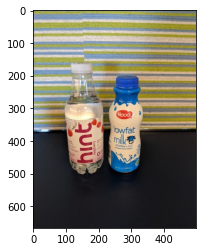

In [ ]:
#load in a test image
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T

test_image = Image.open('odFridgeObjects/images/17.jpg')
plt.imshow(test_image)

Without any additional wrapping, the output of this model looks like:

In [ ]:
model.eval()
detections = model(T.ToTensor()(test_image).to(device).unsqueeze(0))


# 3. Setting up D-RISE Model Wrapper

D-RISE expects a common model output format, which is a list of "Detection Records". The wrapper for Faster R-CNN is written here (and it's the default option in the package) - if your model is of a different type, you have to write a wrapper to match this output type before you continue. Writing a customized wrapper should be pretty straightforward - the only requirement is that the wrapped model output should return a list of DetectonRecords, with attributes bounding_boxes, class_scores, and objectness_scores.

In [ ]:
from vision_explanation_methods.explanations import common as od_common

class PytorchFasterRCNNWrapper(od_common.GeneralObjectDetectionModelWrapper):
    """Wraps a PytorchFasterRCNN model with a predict API function for object detection.

    To be compatible with the drise explainability method, all models must be wrapped to have
    the same output and input class.
    This wrapper is customized for the FasterRCNN model from Pytorch, and can
    also be used with the RetinaNet or any other models with the same output class.
    """
    
    def __init__(self, model, number_of_classes: int):
        self._model = model
        self._number_of_classes = number_of_classes

    def predict(self, x: torch.Tensor):
        """Creates a list of detection records from the image predictions.
        """
        raw_detections = self._model(x)

        def apply_nms(orig_prediction: dict, iou_thresh: float=0.5):
            """Performs non maximum suppression on the predictions according to their intersection-over-union.
            """
            keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

            nms_prediction = orig_prediction
            nms_prediction['boxes'] = nms_prediction['boxes'][keep]
            nms_prediction['scores'] = nms_prediction['scores'][keep]
            nms_prediction['labels'] = nms_prediction['labels'][keep]
            return nms_prediction
        
        def filter_score(orig_prediction: dict, score_thresh: float=0.5):
            """Filters out model predictions with confidence scores below score_thresh
            """
            keep = orig_prediction['scores'] > score_thresh

            filter_prediction = orig_prediction
            filter_prediction['boxes'] = filter_prediction['boxes'][keep]
            filter_prediction['scores'] = filter_prediction['scores'][keep]
            filter_prediction['labels'] = filter_prediction['labels'][keep]
            return filter_prediction
        
        detections = [] 
        for raw_detection in raw_detections:
            raw_detection = apply_nms(raw_detection,0.005)
            
            # Note that FasterRCNN doesn't return a score for each class, only the predicted class
            # DRISE requires a score for each class. We approximate the score for each class
            # by dividing the (1.0 - class score) evenly among the other classes.
            
            raw_detection = filter_score(raw_detection, 0.5)
            expanded_class_scores = od_common.expand_class_scores(raw_detection['scores'],
                                                                  raw_detection['labels'],
                                                                  self._number_of_classes)
            detections.append(
                od_common.DetectionRecord(
                    bounding_boxes=raw_detection['boxes'],
                    class_scores=expanded_class_scores,
                    objectness_scores=torch.tensor([1.0]*raw_detection['boxes'].shape[0]),
                    
                )
            )
        
        return detections

Now for the fun part - we are ready to run the model to get the wrapped detection outputs and visualize them with saliency maps.

# 4. Using the vision-explanation-methods package
To generate saliency maps, import DRISE_runner from vision-explanations-method and run get_drise_saliency_map with following parameters.

---

    imagelocation: str - path of the input image
    model: Optional[object] - PyTorch model (default: Faster R-CNN)
    modellocation: Optional[str] - path of the model weights
    numclasses: int - number of classes model predicts
    savename: str - name of output saliency map image
    nummasks: int=25 - number of masks to use for saliency
    maskres: Tuple[int, int]=(4,4) - resolution of masks before scale-up
    maskpadding: Optional[int]=None - how much to pad the mask before cropping
    devicechoice: Optional[str]=None - device to use to run D-RISE
    wrapperchoice: Optional[object] = PytorchFasterRCNNWrapper - wrapper function for D-RISE


In [ ]:
from vision_explanation_methods import DRISE_runner as dr

loading user fastercnn model


100%|██████████| 24/24 [00:00<00:00, 140.45it/s]


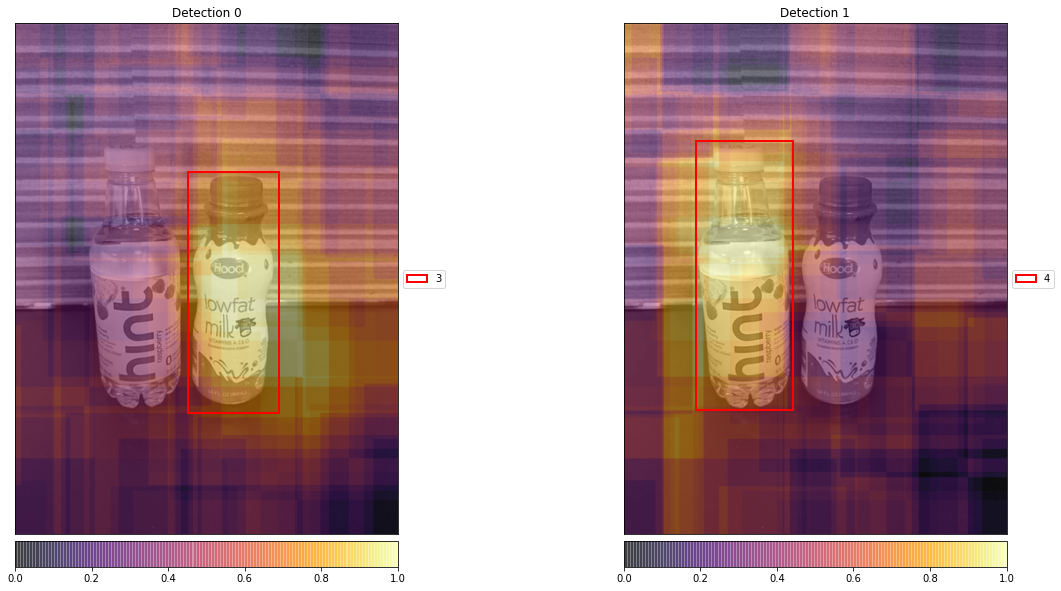

In [ ]:
res = dr.get_drise_saliency_map('odFridgeObjects/images/17.jpg', None, 'Recycling_finetuned_FastRCNN.pt', 5, 'outputmap.jpg')